In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 4107, done.
remote: Counting objects: 100% (4107/4107), done.
remote: Compressing objects: 100% (3109/3109), done.
remote: Total 4107 (delta 1188), reused 2031 (delta 936), pack-reused 0
Receiving objects: 100% (4107/4107), 45.35 MiB | 19.10 MiB/s, done.
Resolving deltas: 100% (1188/1188), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 42.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 43.1 MB/s eta 0:00:00
     ━━━━━━━

In [ ]:
!pip install tensorflow=="2.15.0"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 475.2/475.2 MB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 33.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 14.0 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.3.2
    Uninstalling ml-dtypes-0.3.2:
      Successfully uninstalled ml-dtypes-0.3.2
  Attempting uninstall: keras
    Found existing installation: keras 3.3.3
    Uninstalling keras-3.3.3:
      Successfully uninstalled keras-3.3.3
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.16.2
    Uninstalling tensorboard-2.16.2:
      Successfully uninstalled tensorboard-2.16.2
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.16.1
    Uninstalling tensorflow-2.16.1:
      Successfully uninstalled tensorflow-2.16.1
ERROR: pip's dependency

In [ ]:
import tensorflow as tf
detection_model = tf.saved_model.load('/content/drive/MyDrive/IACV/Models/resnet_exported/saved_model')

In [ ]:
from google.colab.patches import cv2_imshow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data, color, img_as_ubyte
from skimage.feature import canny
from skimage.transform import hough_ellipse
from skimage.draw import ellipse_perimeter
import math

SCORE_TRESHOLD = 0.5
EXPANSION_FACTOR = 0.01
BINARY_IMAGE_TRESHOLD = 160
CANNY_LOW_TRESHOLD = 180
CANNY_HIGH_TRESHOLD = 200
WHEEL_TEMPLATE = cv2.imread("/content/drive/My Drive/IACV/wheel_template.png")[:,:,0]

def convert_bb_to_opencv(bb, frame):
  start = (int(bb[1] * frame.shape[1]), int(bb[0] * frame.shape[0]))
  end = (int(bb[3] * frame.shape[1]), int(bb[2] * frame.shape[0]))
  return start, end

def convert_bbox_to_xywh(bbox, frame):
  bbox = convert_bb_to_opencv(bbox, frame)
  top_left = bbox[0]
  bottom_right = bbox[1]

  x = top_left[0]
  y = top_left[1]
  width = bottom_right[0] - top_left[0]
  height = bottom_right[1] - top_left[1]

  return (x, y, width, height)

def add_bbox_to_frame(detection, frame):
  s, e = convert_bb_to_opencv(detection, frame)
  new_frame =  cv2.rectangle(frame, s, e, (0, 255, 0), 2)
  return new_frame

def infer_boxes(frame, model):
    input_tensor = tf.convert_to_tensor([frame], dtype=tf.uint8)
    detections = model(input_tensor)

    boxes = []
    for i, d in enumerate(detections['detection_scores'][0]):
      if d > SCORE_TRESHOLD:
        boxes.append(detections['detection_boxes'][0][i])

    return boxes

def add_boxes_to_frame(boxes, frame):
    for bbox in boxes:
      frame = add_bbox_to_frame(bbox, frame)

    return frame

def detect_wheels_ellipses(boxes, image):
  best_matches = []
  for box in boxes:
    x, y, w, h = convert_bbox_to_xywh(box, image)
    bbc_x, bbc_y = x+(w // 2), y+(h // 2)
    patch = image[y:y+h, x:x+w]

    gray_image = cv2.cvtColor(patch, cv2.COLOR_BGR2GRAY)
    gray_image = cv2.equalizeHist(gray_image)
    _, binary_image = cv2.threshold(gray_image, BINARY_IMAGE_TRESHOLD, 255, cv2.THRESH_BINARY)
    binary_image = cv2.medianBlur(binary_image, ksize=5)

    edges = cv2.Canny(binary_image, CANNY_LOW_TRESHOLD, CANNY_HIGH_TRESHOLD)
    contours, _ = cv2.findContours(edges, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    #input_height, input_width = gray_image.shape[:2]
    #template = cv2.resize(WHEEL_TEMPLATE, (input_width, input_height), interpolation=cv2.INTER_AREA)

    best_match_val = None
    best_match_ellipse = None
    for c in contours:
      if(len(c) < 5): continue
      ellipse = cv2.fitEllipse(c)
      (center, axes, angle) = ellipse

      if not math.isnan(center[0]) and not math.isnan(center[1]):
        new_center = (int(center[0] + x), int(center[1] + y))
        new_ellipse = (new_center, axes, angle)

        e_w, e_h = axes
        if(e_w < w / 2 or e_h < h / 2):
          continue

        ellipse_points = cv2.ellipse2Poly(new_center, (int(e_w/2), int(e_h/2)), int(angle), 0, 360, 10)

        if(not all(x <= point[0] <= x+w and y <= point[1] <= y+h for point in ellipse_points)):
          continue

        ellipse_mask = np.zeros_like(gray_image)
        cv2.ellipse(ellipse_mask, ellipse, (255, 255, 255), -1)
        ellipse_roi = cv2.bitwise_and(binary_image, ellipse_mask)

        '''
        result = cv2.matchTemplate(ellipse_roi, template, cv2.TM_CCOEFF_NORMED)
        _, max_val, _, max_loc = cv2.minMaxLoc(result)

        if(best_match_val == None or max_val > best_match_val):
          best_match_dist = max_val
          best_match_ellipse = new_ellipse
        '''

        dist = math.sqrt((bbc_x - new_center[0])**2 + (bbc_y - new_center[1])**2)

        if(best_match_val == None or dist > best_match_val):
            best_match_dist = dist
            best_match_ellipse = new_ellipse

    if(best_match_ellipse == None): continue
    best_matches.append(best_match_ellipse)
    image = cv2.ellipse(image, best_match_ellipse, (0, 255, 0), 2)
    image = cv2.circle(image, (bbc_x, bbc_y), 5, (255, 0, 255), -1)
  return image, best_matches

def detect_features_points(ellipses, frame):
  points = []
  for ellipse in ellipses:
    (center, axes, angle) = ellipse
    e_w, e_h = axes
    ellipse_points = cv2.ellipse2Poly(center, (int(e_w/2), int(e_h/2)), int(angle), 0, 360, 10)
    p1 = max(ellipse_points, key=lambda point: point[1]) # CONTACT POINT
    p2 = min(ellipse_points, key=lambda point: point[1]) # TOP POINT
    p3 = (min(ellipse_points, key=lambda point: point[0])[0], (abs(p1[1] - p2[1])//2) + p2[1]) # LEFT
    p4 = (max(ellipse_points, key=lambda point: point[0])[0], (abs(p1[1] - p2[1])//2) + p2[1]) # RIGHT
    points.append([p1,p2,p3,p4])

    frame = cv2.circle(frame, (p1[0], p1[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p2[0], p2[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p3[0], p3[1]), 5, (0, 0, 255), -1)
    frame = cv2.circle(frame, (p4[0], p4[1]), 5, (0, 0, 255), -1)

  return frame, points

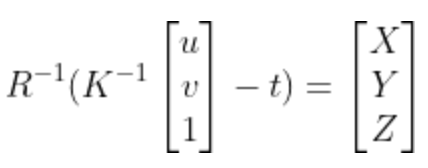





In [ ]:
WHEEL_RADIUS = 20
WHEELS_MODEL = np.array([(0,WHEEL_RADIUS,0),(0,-WHEEL_RADIUS,0),(-WHEEL_RADIUS,0,0),(WHEEL_RADIUS,0,0)], dtype='float32')

def compute_camera_pose(pts, pts3d, K, d):
  return cv2.solvePnP(pts3d, pts, K, d)

def image_to_word(pt, K, rvec, tvec):
  R, _ = cv2.Rodrigues(rvec)
  return np.dot(np.linalg.inv(R),((np.dot(np.linalg.inv(K), np.vstack((pt,np.array([[1]]))))) - tvec))

In [ ]:
from tqdm import tqdm
import pandas as pd
import pickle
import plotly.graph_objects as go

video_path = '/content/drive/My Drive/IACV/Videos/video_straight_hill.mp4'
cap = cv2.VideoCapture(video_path)

num_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
progress_bar = tqdm(total = num_frames, desc='Video processing progress', position=0, leave=True)

frame_width = int(cap.get(3))
frame_height = int(cap.get(4))

output_video_path = '/content/drive/My Drive/IACV/Processed_videos/F_RCNN_Geometric_video_straight_hill.mp4'
out = cv2.VideoWriter(output_video_path, cv2.VideoWriter_fourcc(*'mp4v'), 30, (frame_width, frame_height))

f = open("/content/drive/My Drive/IACV/calibration/cameraMatrix.pkl", 'rb')
data = pickle.load(f)
K = np.array(data)
f.close()

f = open('/content/drive/My Drive/IACV/calibration/dist.pkl', 'rb')
data = pickle.load(f)
d = np.array(data).reshape(-1)
f.close()

world_points = []
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
      break

    if frame is not None:
        boxes = infer_boxes(frame, detection_model)
        processed_frame = add_boxes_to_frame(boxes, frame)
        processed_frame, ellipses = detect_wheels_ellipses(boxes, processed_frame)
        processed_frame, feature_points = detect_features_points(ellipses, processed_frame)

        if(len(feature_points) >= 1): # if there is at least 1 ellipse detected
          success, rvec, tvec = compute_camera_pose(np.array(feature_points[0]).astype('float32'), WHEELS_MODEL, K, d)
          world_points.append(image_to_word(np.array([feature_points[0][0]]).T, K, rvec, tvec).reshape(-1))
          #world_points.append((np.dot(R.reshape(-1), np.append(feature_points[0][0],1)) + t).reshape(-1))

          if(len(feature_points) == 2): # if there is another ellipse back-project the contact point
            #world_points.append((np.dot(R.reshape(-1), np.append(feature_points[1][0],1)) + t).reshape(-1))
            world_points.append(image_to_word(np.array([feature_points[1][0]]).T, K, rvec, tvec).reshape(-1))

        #cv2_imshow(processed_frame)

        out.write(processed_frame)
        progress_bar.update(1)

cap.release()
out.release()

pd.DataFrame(world_points).to_csv('/content/drive/My Drive/IACV/Point_coluds/F_RCNN_Geometric_video_straight_hill.csv', index=False)

Video processing progress: 100%|██████████| 579/579 [32:13<00:00,  3.06s/it]